In [1]:
import dask.dataframe as dd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from scipy.interpolate import interp1d
import extinction as ext
import math
from scipy.optimize import curve_fit
import scipy.optimize

with open('meta.pickle','rb') as handle:
    meta = pickle.load(handle)
print(meta)

{'SN2009ip': {'event': 'SN2009ip', 'quality': 1, 'maxOptical': 56206.21, 'type': 'SNIIn', 'ebvGal': 0.0157, 'redshift': 0.005944, 'lumdistMpc': 26.426, 'UVdefPhase': 12.0, 'UVdefTemperature': 10000.0}, 'SN2013fs': {'event': 'SN2013fs', 'quality': 1, 'maxOptical': 56577.3198, 'type': 'SNIIn', 'ebvGal': 0.0346, 'redshift': 0.011855, 'lumdistMpc': 52.9417, 'UVdefPhase': 15.0}, 'SN1998S': {'event': 'SN1998S', 'quality': 3, 'maxOptical': 50890.4, 'type': 'SNIIn', 'ebvGal': 0.0202, 'redshift': 0.00302, 'lumdistMpc': 15.0, 'UVdefPhase': None}, 'PTF11iqb': {'event': 'PTF11iqb', 'quality': 1, 'maxOptical': 55779.47, 'type': 'SNIIn', 'ebvGal': 0.0278, 'redshift': 0.0125, 'lumdistMpc': 55.85, 'UVdefPhase': None}, 'SN2007pk': {'event': 'SN2007pk', 'quality': 1, 'maxOptical': 54423.34, 'type': 'SNIIn', 'ebvGal': 0.0448, 'redshift': 0.016655, 'lumdistMpc': 74.6463, 'UVdefPhase': None}, 'SN2012aw': {'event': 'SN2012aw', 'quality': 2, 'maxOptical': 56011.04, 'type': 'SNIIP', 'ebvGal': 0.0239, 'redshif

In [274]:
def mag2flux(mag,wave):
    import numpy as np
    mag = np.array(mag)
    wave = np.array(wave)
    return 10**(-0.4*(mag + 2.406 + 5*np.log10(wave)))

def mag2eflux(f,dm):
    import numpy as np
    f = np.array(f)
    dm = np.array(dm)
    return f * np.log(10.) * 0.4 * dm

def linear(x,m,c):
    import numpy as np
    x = np.array(x)
    return m*x + c

def quad(x,a,b,c):
    import numpy as np
    x = np.array(x)
    return a*(x-b)**2 + c

def invquad(x,a,b,c):
    return 1./quad(x,a,b,c)

def power(x,a,b,c):
    import numpy as np
    x = np.array(x)
    return a*(x/b)**c

def expo(x,a,b):
    import numpy as np
    x = np.array(x)
    return a * np.exp(b * x)

def expo2(x,a,b,c):
    import numpy as np
    x = np.array(x)
    return a * np.exp(b*x**2 + c*x)

def planck(wave,temp,scale=1.):
    import numpy as np
    w = np.array(wave) / 1e8 # A to cm
    c1 = 3.7417749e-5 # 2 pi h c c
    c2 = 1.4387687 # h c / k
    val = c2/w/temp
    bbflux = c1 / (w**5 * np.expm1(val))
    return 1e-8 * scale * bbflux # erg/s/cm**2/A

def planckWithBlanket(wave,temp,scale=1.,pow=1.):
    import numpy as np
    wave = np.array(wave)
    trans = wave/4000.
    trans[trans>1.] = 1.
    return planck(wave,temp,scale) * trans**pow

def twoplanck(wave,temp,scale,temp2,scale2):
    return planck(wave,temp,scale) + planck(wave,temp2,scale2)

def temperature2fluxratio(temp,w1,w2):
    return planck(w1,temp)/planck(w2,temp)

In [3]:
wavelength = {'UVW2': 1928.,
            'UVM2': 2246.,
            'UVW1': 2600.,
            'U': 3571.,
            'B': 4344.,
            'V': 5456.,
            'R': 6442.,
            'I': 7994.,
            'J': 12355.,
            'H': 16458.,
            'KS': 21603., "K'": 21603.,
            'I1': 35500.,
            'I2': 44930.,
            'I3': 57310.,
            'I4': 78720.}

# values = mAB - mVega
# Swift calibration (UVW2--V): https://swift.gsfc.nasa.gov/analysis/uvot_digest/zeropts.html
# RI calibration: http://www.astronomy.ohio-state.edu/~martini/usefuldata.html
vega2AB = {'UVW2': 1.73,
          'UVM2': 1.69,
          'UVW1': 1.51,
          'U': 1.02,
          'B': -0.13,
          'V': -0.01,
          'R': 0.21,
          'I': 0.45,
          'H': 1.39,
          'J': 0.91,
          'KS': 1.85, "K'": 1.85}

In [4]:
# load data
s1 = 'https://api.sne.space/'
event = 'SN2009ip'
s3 = '/photometry/time+instrument+telescope+model+realization+magnitude+e_magnitude+zeropoint+band+bandset+system+upperlimit?format=csv'
sn = pd.read_csv(s1+event+s3)

In [5]:
# filter
x = sn.copy()
x = x[x['upperlimit']=='F']
for i in {'J','H','KS','I1','I2'}:
    x = x[x['band']!=i]
x.drop(['instrument','telescope','model','realization','zeropoint','bandset','system','upperlimit'],axis=1,inplace=True)
sn = x.copy()

In [6]:
# galactic extinction: apparent - extinction = absolute
x = []
sn.reset_index(drop=True, inplace=True)
for i in sn.index:
    x.append(sn['magnitude'].iloc[i] - ext.fm07(np.array([wavelength[sn['band'].iloc[i]]]), 3.1*meta[event]['ebvGal'])[0])
sn['magnitude_correct'] = x

# phase
sn['phase'] = (sn['time'] - meta[event]['maxOptical'])/(1. + meta[event]['redshift'])

# AB conversion
x = []
sn.reset_index(drop=True,inplace=True)
for i in sn.index:
    x.append(sn['magnitude_correct'].iloc[i] + vega2AB[sn['band'].iloc[i]])
sn['magAB'] = x

# AB to flux
x = []
sn.reset_index(drop=True,inplace=True)
for i in sn.index:
    x.append(wavelength[sn['band'].iloc[i]])
sn['waveobs'] = x
sn['flamobs'] = mag2flux(sn['magAB'],x)
sn['e_flamobs'] = mag2eflux(sn['flamobs'],sn['e_magnitude'])

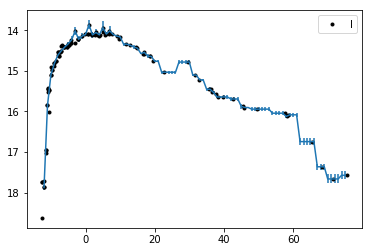

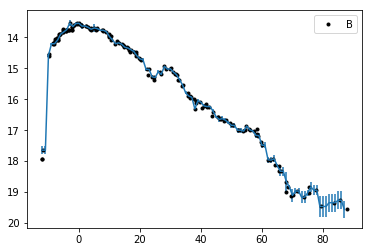

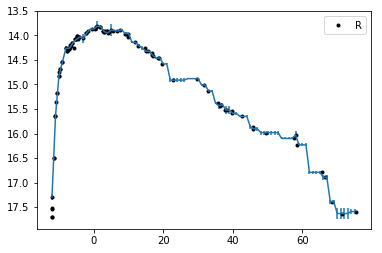

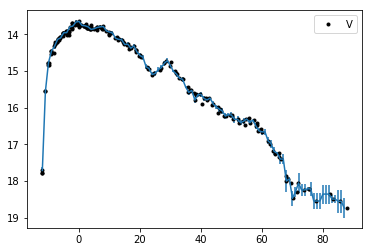

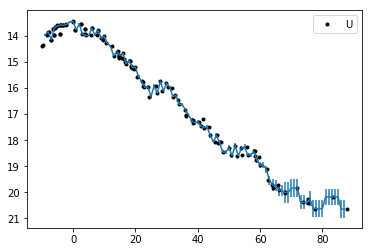

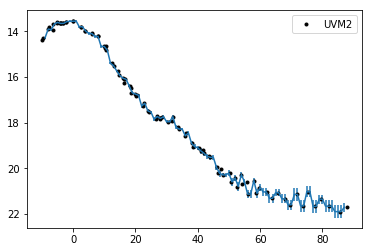

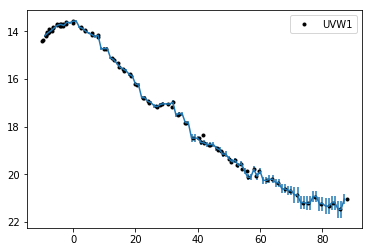

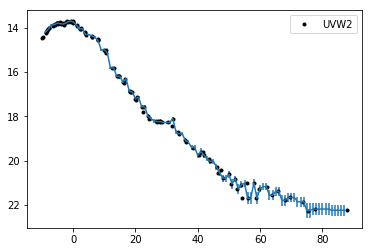

In [8]:
# interpolate
tmin = -13
tmax = 100

a = sn.copy()
a = a[a['phase']>=tmin]
a = a[a['phase']<=tmax]

interpolModel = {}
for i in a['band'].unique():
    x = a[a['band']==i]
    interpolModel[(event,i)] = {}
    interpolModel[(event,i)]['magAB'] = interp1d(x['phase'],x['magAB'],kind='nearest')
    interpolModel[(event,i)]['e_magnitude'] = interp1d(x['phase'],x['e_magnitude'],kind='nearest')
    interpolModel[(event,i)]['trange'] = (math.ceil(min(x['phase'])),math.floor(max(x['phase']))+1)
    
    plt.figure()
    plt.plot(x['phase'],x['magAB'],'k.',label=i)
    tgrid = np.arange(interpolModel[(event,i)]['trange'][0],interpolModel[(event,i)]['trange'][1],step=1)
    plt.errorbar(tgrid
                 ,interpolModel[(event,i)]['magAB'](tgrid)
                 ,interpolModel[(event,i)]['e_magnitude'](tgrid))
    plt.gca().invert_yaxis()
    plt.legend()
    plt.show()

# Blackbody optical component

In [176]:
tmin=-12
tmax=61
tgrid=np.arange(tmin,tmax,step=1)
temperature = {}

#########################################################################################

bandopt=['B','V','R','I']
temperature[(event,'opt')] = {}
for i in tgrid:
    w = []
    f = []
    ef = []
    for j in bandopt:
        try:
            x = mag2flux(interpolModel[(event,j)]['magAB'](i),wavelength[j])
            f.append(x)
            ef.append(mag2eflux(x,interpolModel[(event,j)]['e_magnitude'](i)))
            w.append(wavelength[j])
        except:
            continue
    
    popt,pcov = curve_fit(planck,w,f,sigma=ef,p0=[10000.,1e-23])
    temperature[(event,'opt')][i] = (popt,pcov)
    
#########################################################################################

bandopt=['UVW2','UVM2','UVW1']
temperature[(event,'UV')] = {}
for i in tgrid:
    w = []
    f = []
    ef = []
    for j in bandopt:
        try:
            x = mag2flux(interpolModel[(event,j)]['magAB'](i),wavelength[j])
            f.append(x)
            ef.append(mag2eflux(x,interpolModel[(event,j)]['e_magnitude'](i)))
            w.append(wavelength[j])
        except:
            continue
    try:
        popt,pcov = curve_fit(planck,w,f,sigma=ef,p0=[10000.,1e-23])
    except:
        continue
    temperature[(event,'UV')][i] = (popt,pcov)

C:\Users\Kornpob\Anaconda3\lib\site-packages\ipykernel_launcher.py:34: RuntimeWarning: overflow encountered in exp


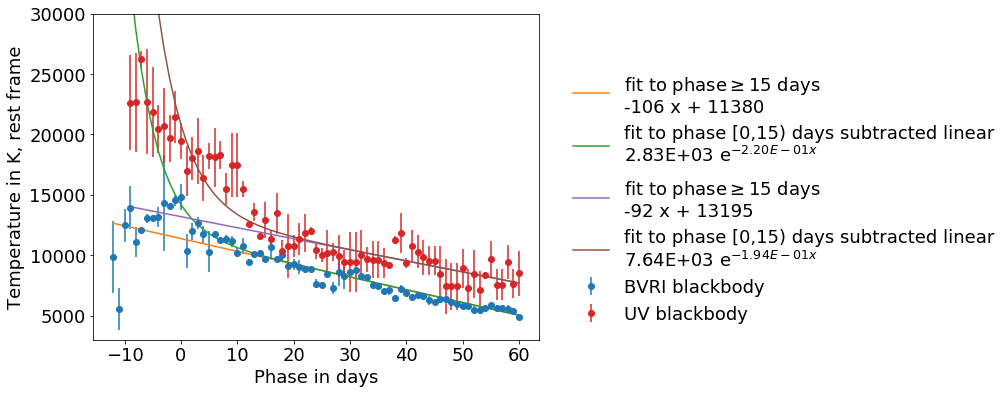

In [297]:
x = temperature[(event,'opt')]
a = []
b = []
eb = []
for i in x.keys():
    a.append(i)
    b.append(x[i][0][0])
    eb.append(np.sqrt(x[i][1][0,0]))
plt.figure(figsize = (8,6))
a = np.array(a)
b = np.array(b)*(1.+meta[event]['redshift'])
eb = np.array(eb)*(1.+meta[event]['redshift'])
plt.errorbar(a,b,eb,marker='o',linestyle='',label='BVRI blackbody')

index = np.argwhere(a>=15).flatten()
popt,pcov = curve_fit(linear,a[index],b[index],sigma=eb[index],p0=[-1,15000])
temperature[(event,'opt_linear')] = (popt,pcov)
plt.plot(a,linear(a,*popt),label='fit to phase$\geq$15 days\n{0:.0f} x + {1:.0f}'.format(*popt))

index = np.intersect1d(np.argwhere(a>=0).flatten(),np.argwhere(a<15).flatten())
bb = b - linear(a,*popt)
index = np.intersect1d(index,np.argwhere(bb>=0).flatten())
popt2,pcov2 = curve_fit(expo,a[index],bb[index],sigma=eb[index],p0=[1,-1])
temperature[(event,'opt_expo')] = (popt2,pcov2)
plt.plot(a,linear(a,*popt) + expo(a,*popt2),label='fit to phase [0,15) days subtracted linear\n{0:.2E} e$^{{{1:.2E} x}}$'.format(*popt2))

#####################################################################################################

x = temperature[(event,'UV')]
a = []
b = []
eb = []
for i in x.keys():
    a.append(i)
    b.append(x[i][0][0])
    eb.append(np.sqrt(x[i][1][0,0]))
a = np.array(a)
b = np.array(b)*(1.+meta[event]['redshift'])
eb = np.array(eb)*(1.+meta[event]['redshift'])
plt.errorbar(a,b,eb,marker='o',linestyle='',label='UV blackbody')

# index = np.argwhere(a>=0).flatten()
# popt,pcov = curve_fit(invquad,a[index],b[index],sigma=eb[index],p0=[1,1,1])
# temperature[(event,'opt_linear')] = (popt,pcov)
# plt.plot(a,invquad(a,*popt),linestyle='--'
#          ,label='fit to phase$\geq$0 days\n({0:.2E} (x - {1:.2E})$^2$ + {2:.2E})$^{{-1}}$'.format(popt[0],popt[1],popt[2]))

index = np.argwhere(a>=15).flatten()
popt,pcov = curve_fit(linear,a[index],b[index],sigma=eb[index],p0=[-1,15000])
temperature[(event,'UV_linear')] = (popt,pcov)
plt.plot(a,linear(a,*popt),label='fit to phase$\geq$15 days\n{0:.0f} x + {1:.0f}'.format(*popt))

index = np.intersect1d(np.argwhere(a>=0).flatten(),np.argwhere(a<15).flatten())
bb = b - linear(a,*popt)
index = np.intersect1d(index,np.argwhere(bb>0).flatten())
popt2,pcov2 = curve_fit(expo,a[index],bb[index],sigma=eb[index],p0=[1,-1])
temperature[(event,'UV_expo')] = (popt2,pcov2)
plt.plot(a,linear(a,*popt) + expo(a,*popt2),label='fit to phase [0,15) days subtracted linear\n{0:.2E} e$^{{{1:.2E} x}}$'.format(*popt2))

########################################################################################################

plt.ylim(3000,30000)
plt.xticks(fontsize=18)
plt.xlabel('Phase in days',fontsize=18)
plt.yticks(fontsize=18)
plt.ylabel('Temperature in K, rest frame',fontsize=18)
# plt.title('SN2009ip, BVRI fit to a blackbody',fontsize=18)
lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
plt.savefig(r'D:\Model_SED_IIn\plot_97_SN2009ip_tempopt.eps', format='eps', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()


# UV deficit

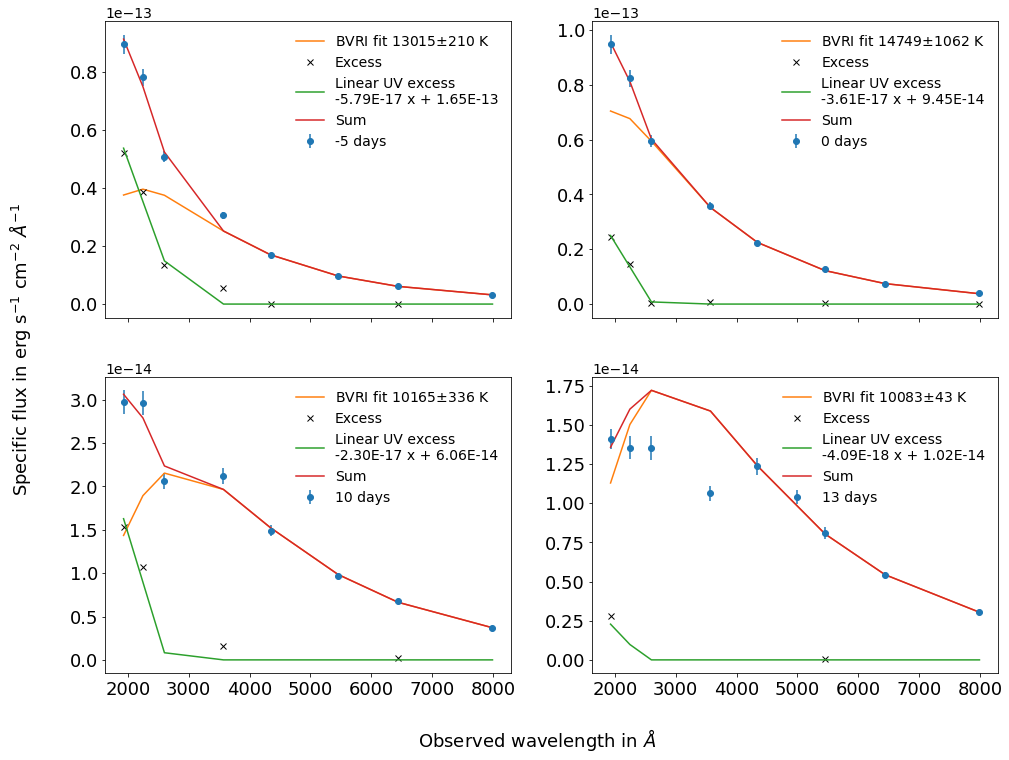

In [174]:
tgrid = np.array([-5,0,10,13])
# tgrid = np.arange(-5,61,step=2)
fig, axes = plt.subplots(2,2,sharex=True,figsize=(16,12))
fig.text(0.5,0.04,'Observed wavelength in $\AA$',fontsize=18,ha='center')
fig.text(0.04,0.5,'Specific flux in erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$',fontsize=18,va='center',rotation='vertical')
for i in tgrid:
    popt = temperature[(event,'opt')][i][0]
    pcov = temperature[(event,'opt')][i][1]
    band = ['UVW2','UVM2','UVW1','U','B','V','R','I']
    w = []
    f = []
    ef = []
    
    for j in band:
        try:
            x = mag2flux(interpolModel[(event,j)]['magAB'](i),wavelength[j])
            f.append(x)
            ef.append(mag2eflux(x,interpolModel[(event,j)]['e_magnitude'](i)))
            w.append(wavelength[j])
        except:
            continue
            
    sub = np.array([[0,0],[0,1],[1,0],[1,1]])
    loc = sub[np.argwhere(tgrid==i).flatten().flatten()]
    
    locsub = axes[loc[0][0],loc[0][1]]
    locsub.errorbar(w,f,ef,marker='o',linestyle='',label='{0} days'.format(i))
    locsub.plot(w,planck(w,*popt),label='BVRI fit {0:.0f}$\pm${1:.0f} K'.format(popt[0],np.sqrt(pcov[0,0])))
    
    f = f - planck(w,*popt)
    index = np.argwhere(f>0.).flatten()
    w,f = np.array(w),np.array(f)
    locsub.plot(w[index],f[index],'kx',label='Excess')
    
    x = np.array(w[0:3])
    f = f[0:3]
    f[f<0] = 0.
    popt2,pcov2 = curve_fit(linear,x,f,p0=[-1,0])
    f = linear(w,*popt2)
    f[f<0.]=0.
    locsub.plot(w,f,label='Linear UV excess\n{0:.2E} x + {1:.2E}'.format(popt2[0],popt2[1]))
    
    f = f + planck(w,*popt)
    locsub.plot(w,f,label='Sum')
    
    locsub.tick_params(labelsize=18)
    locsub.yaxis.offsetText.set_fontsize(14)
    locsub.legend(fontsize=14, frameon=False)
    
# fig.legend()
# plt.yticks(fontsize=18)
# lgd = fig.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
# plt.savefig(r'D:\Model_SED_IIn\plot_97_SN2009ip_SED.eps', figsize=(16,12), format='eps', dpi=10000, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.savefig(r'D:\Model_SED_IIn\plot_97_SN2009ip_SED.eps', figsize=(16,12), format='eps', dpi=1000, bbox_extra_artists=(lgd,))
plt.show()

# Excess evolution

C:\Users\Kornpob\Anaconda3\lib\site-packages\ipykernel_launcher.py:39: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future
C:\Users\Kornpob\Anaconda3\lib\site-packages\ipykernel_launcher.py:47: VisibleDeprecationWarning: converting an array with ndim > 0 to an index will result in an error in the future


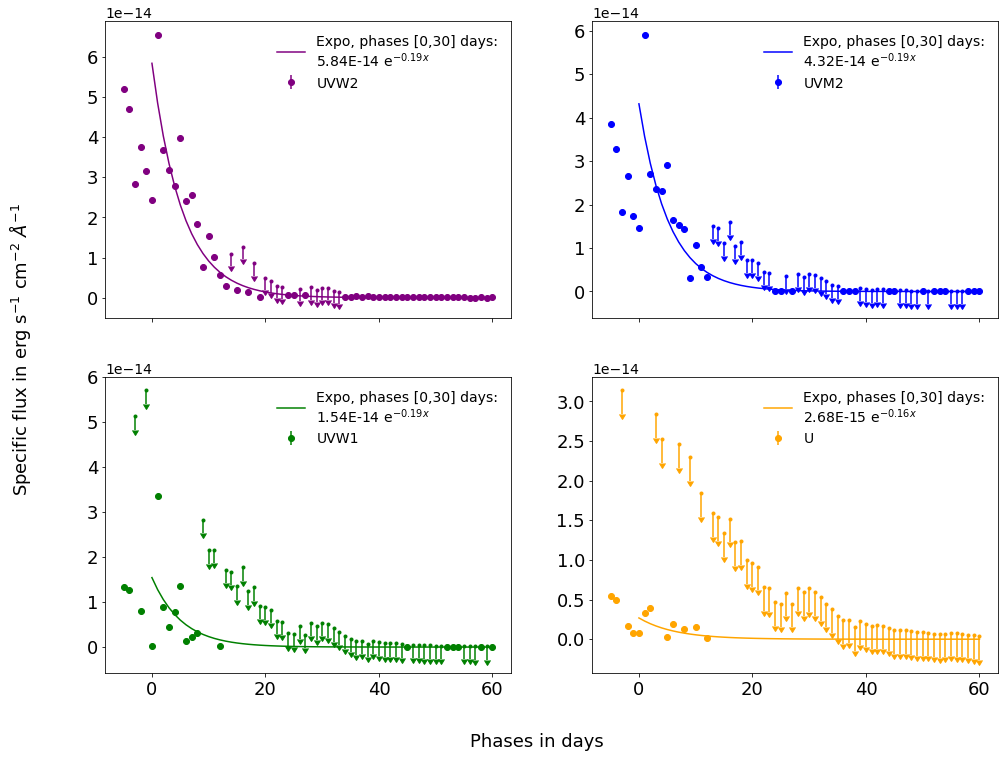

In [173]:
tmin = -5
tmax = 61
# band = ['UVW2','UVM2','UVW1','U','B','V','R','I']
band = ['UVW2','UVM2','UVW1','U']
band = np.array(band)
fig, axes = plt.subplots(2,2,sharex=True,figsize=(16,12))
fig.text(0.5,0.04,'Phases in days',fontsize=18,ha='center')
fig.text(0.04,0.5,'Specific flux in erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$',fontsize=18,va='center',rotation='vertical')

for j in band:
    sub = np.array([[0,0],[0,1],[1,0],[1,1]])
    loc = sub[np.argwhere(band==j).flatten().flatten()]
    locsub = axes[loc[0][0],loc[0][1]]

    tgrid = np.arange(max(tmin,interpolModel[(event,j)]['trange'][0]),min(tmax,interpolModel[(event,j)]['trange'][1])
                     ,step=1)
    f = mag2flux(interpolModel[(event,j)]['magAB'](tgrid),wavelength[j])
    ef = mag2eflux(f,interpolModel[(event,j)]['e_magnitude'](tgrid))
    ff = []
    for i in tgrid:
        popt = temperature[(event,'opt')][i][0]
        ff.append(planck(wavelength[j],*popt))
    fff = f - ff
    upper = [0]*len(fff)
    index = np.argwhere(fff<0.)
    ff,fff,upper = np.array(ff),np.array(fff),np.array(upper)
    fff[index] = ff[index]
    upper[index] = 1
    
    for i in [0,1]:
        marker=['o','.']
        label=[j,'']
        linestyle=['','']
        color=['purple','blue','green','orange']
        index = np.argwhere(upper==i)
        
        
        locsub.errorbar(tgrid[index],fff[index],upper[index]*3e-15,marker=marker[i],uplims=i
                 ,color=color[np.argwhere(np.array(band)==j).flatten()],linestyle=linestyle[i]
                 ,label=label[i])
    
    index = np.intersect1d(np.argwhere(upper==0).flatten(),np.argwhere(tgrid>=0).flatten())
    index = np.intersect1d(index,np.argwhere(tgrid<=30).flatten())
    popt,pcov = curve_fit(expo,tgrid[index],fff[index],sigma=ef[index],p0=[1,-1])
    index = np.argwhere(tgrid>=0).flatten()
    locsub.plot(tgrid[index],expo(tgrid[index],*popt)
             ,color=color[np.argwhere(np.array(band)==j).flatten()]
             ,label='Expo, phases [0,30] days:\n{0:.2E} e$^{{{1:.2f}x}}$'.format(popt[0],popt[1]))
    
    locsub.tick_params(labelsize=18)
    locsub.yaxis.offsetText.set_fontsize(14)
    locsub.legend(fontsize=14, frameon=False)
    
#     plt.xticks(fontsize=18)
#     plt.xlabel('Observed wavelength in $\AA$',fontsize=18)
#     plt.yticks(fontsize=18)
#     plt.ylabel('Specific flux in erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$',fontsize=18)
#     lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
plt.savefig(r'D:\Model_SED_IIn\plot_97_SN2009ip_excess_evolution.eps', format='eps', figsize=(16,12), dpi=1000, bbox_extra_artists=(lgd,))
plt.show()

# BB with blanket

In [171]:
# tgrid = [-5,0,10,13,20,25,30]
# pow=2.
# # tgrid = np.arange(-5,61,step=2)
# for i in tgrid:
#     popt = temperature[(event,'opt')][i][0]
#     pcov = temperature[(event,'opt')][i][1]
#     band = ['UVW2','UVM2','UVW1','U','B','V','R','I']
#     w = []
#     f = []
#     ef = []
#     for j in band:
#         try:
#             x = mag2flux(interpolModel[(event,j)]['magAB'](i),wavelength[j])
#             f.append(x)
#             ef.append(mag2eflux(x,interpolModel[(event,j)]['e_magnitude'](i)))
#             w.append(wavelength[j])
#         except:
#             continue
#     plt.figure(figsize=(8,6))
#     plt.errorbar(w,f,ef,marker='o',linestyle='',label='{0} days'.format(i))
#     plt.plot(w,planckWithBlanket(w,*popt,pow),label='BVRI fit {0:.0f}$\pm${1:.0f} K'.format(popt[0],np.sqrt(pcov[0,0])))
    
#     f = f - planckWithBlanket(w,*popt,pow)
#     f[f<0.]=0.
#     plt.plot(w,f,'kx',label='Subtracted')
    
#     x = np.array(w[0:3])
#     f = f[0:3]
#     popt2,pcov2 = curve_fit(linear,x,f,p0=[-1,0])
#     f = linear(w,*popt2)
#     f[f<0.]=0.
#     plt.plot(w,f,label='Linear {0:.2E} x + {1:.2E}'.format(popt2[0],popt2[1]))
    
#     f = f + planckWithBlanket(w,*popt,pow)
#     plt.plot(w,f,label='Sum')
    
#     plt.xticks(fontsize=18)
#     plt.xlabel('Observed wavelength in $\AA$',fontsize=18)
#     plt.yticks(fontsize=18)
#     plt.ylabel('Specific flux in erg s$^{-1}$ cm$^{-2}$ $\AA^{-1}$',fontsize=18)
#     lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
# #     plt.savefig(r'D:\Model_SED_IIn\plot_97_SN2009ip_SED.eps', format='eps', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
#     plt.show()

# Color evolution

AttributeError: 'numpy.ndarray' object has no attribute 'isin'

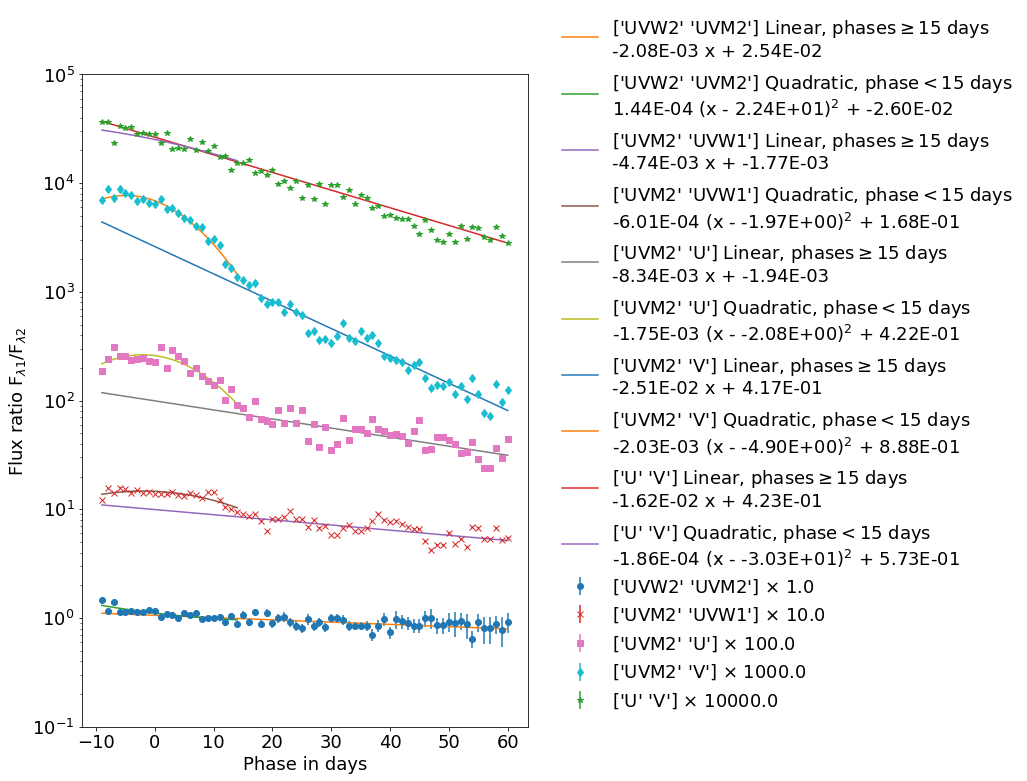

In [268]:
colorpair = np.array([('UVW2','UVM2'),('UVM2','UVW1'),('UVM2','U'),('UVM2','V'),('U','V')])
marker = np.array(['o','x','s','d','*'])
shift = np.array([1.,10.,100.,1000.,10000.])
tmin=-12
tmax=61

j=0
plt.figure(figsize=(8,12))
for i in colorpair:
    tgrid = np.arange(max(tmin,interpolModel[(event,i[0])]['trange'][0],interpolModel[(event,i[1])]['trange'][0])
             ,min(tmax,interpolModel[(event,i[0])]['trange'][1],interpolModel[(event,i[1])]['trange'][1])
             ,step=1)
    f1 = mag2flux(interpolModel[(event,i[0])]['magAB'](tgrid),wavelength[i[0]])
    f2 = mag2flux(interpolModel[(event,i[1])]['magAB'](tgrid),wavelength[i[1]])
    r = f1/f2
    
    ef1 = mag2eflux(f1,interpolModel[(event,i[0])]['e_magnitude'](tgrid))
    ef2 = mag2eflux(f2,interpolModel[(event,i[1])]['e_magnitude'](tgrid))
    er = np.sqrt((ef1/f2)**2 + (ef2*r/f2)**2)
    
    plt.errorbar(tgrid,r*shift[j],er,marker=marker[j],linestyle='',label=r'{0} $\times$ {1}'.format(i,shift[j]))
    
    index = np.argwhere(tgrid>=15).flatten()
    
    lr = np.log10(r)
    elr = er/(r * np.log(10.))
    
    popt,pcov = curve_fit(linear,tgrid[index],lr[index],sigma=elr[index],p0=[-1,1])
    plt.plot(tgrid,10**linear(tgrid,*popt)*shift[j],label='{0} Linear, phases$\geq$15 days\n{1:.2E} x + {2:.2E}'
             .format(i,popt[0],popt[1]))
    
#     r = r - 10**linear(tgrid,*popt)
#     index = np.intersect1d(np.argwhere(r>0.).flatten(),np.argwhere(tgrid<15).flatten())
#     popt2,pcov2 = curve_fit(quad,tgrid[index],np.log10(r[index]),sigma=elr[index],p0=[-1,1,1])
#     plt.plot(tgrid,(10**quad(tgrid,*popt2) + 10**linear(tgrid,*popt)) *shift[j]
#              ,label='{0} Quadratic subtracted linear, phase$<$15 days\n{1:.2E} (x - {2:.2E})$^2$ + {3:.2E}'.format(i,popt2[0],popt2[1],popt2[2]))
    
    index = np.intersect1d(np.argwhere(r>0.).flatten(),np.argwhere(tgrid<15).flatten())
    popt2,pcov2 = curve_fit(quad,tgrid[index],np.log10(r[index]),sigma=elr[index],p0=[-1,1,1])
    plt.plot(tgrid[index],(10**quad(tgrid[index],*popt2) ) *shift[j]
             ,label='{0} Quadratic, phase$<$15 days\n{1:.2E} (x - {2:.2E})$^2$ + {3:.2E}'.format(i,popt2[0],popt2[1],popt2[2]))
    
    j += 1
    
plt.ylim(0.1,100000.)
plt.yscale('log')
plt.yticks(fontsize=18)
plt.xticks(fontsize=18)
plt.xlabel('Phase in days',fontsize=18)
plt.ylabel('Flux ratio F$_{\lambda1}$/F$_{\lambda2}$',fontsize=18)
lgd = plt.legend(bbox_to_anchor=(1.04,0), loc='lower left', fontsize=18, frameon=False)
plt.savefig(r'D:\Model_SED_IIn\plot_97_SN2009ip_colorindex.eps', format='eps', dpi=1000, bbox_extra_artists=(lgd,), bbox_inches='tight')
plt.show()

# UVOIR Lum

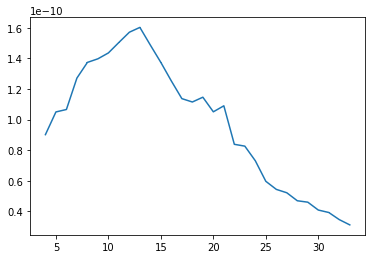

In [255]:
tmin = -9.
tmax = 21.
texp = -13.

tgrid = np.arange(tmin,tmax,step=1)
band = ['UVW2','UVM2','UVW1','U','B','V','R','I']
lum = []
elum = []
for i in tgrid:
    w = []
    f = []
    ef = []
    for j in band:
        try:
            x = mag2flux(interpolModel[(event,j)]['magAB'](i),wavelength[j])
            f.append(x)
            ef.append(mag2eflux(x,interpolModel[(event,j)]['e_magnitude'](i)))
            w.append(wavelength[j])
        except:
            continue
    w,f,ef = np.array(w),np.array(f),np.array(ef)
    lum.append(np.trapz(f,w))
    elum.append(np.sqrt(np.trapz(ef**2,w)))

lum,elum = np.array(lum),np.array(elum)
plt.figure()
plt.errorbar(tgrid-texp,lum,elum)
plt.show()

A = 4.*3.14159*(meta[event]['lumdistMpc'] * 3.086e24)**2
a = [tgrid-texp, lum*A, elum*A]
pd.DataFrame(a).T.to_csv('SN2009ip_UVOIRlum.dat', index=False, header=None, sep=' ')